In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import final_project.config as c
from final_project.logic.Utils import convert_to_absolute_cameras
from final_project.logic.Projection import project
from final_project.logic.Triangulation import triangulate

COLORS = ["#762a83", "#de77ae", "gold", "cyan", "#1b7837"]
POPULATION, SAMPLE = "Population", "Sample"

In [2]:
SEED = 2022

def sample_representatives(tracks: pd.DataFrame, size: int):
    track_lengths = tracks.groupby(level=c.TrackIdx).size()
    length_frequencies = track_lengths.value_counts(normalize=True)
    unique_values = track_lengths.unique()

    rng = np.random.default_rng(SEED)  # see https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
    sample_idxs = np.array([])
    for v in unique_values:
        track_idxs = track_lengths[track_lengths == v].index.to_numpy()
        sample_size = round(length_frequencies[v] * size)
        if sample_size == 0:
            sample_size = 1  # make sure we have at least one of each
        chosen_idxs = rng.choice(track_idxs, size=sample_size, replace=False)
        sample_idxs = np.append(sample_idxs, chosen_idxs)
    return pd.concat([tracks.xs(track_id, level=c.TrackIdx, drop_level=False) for track_id in sample_idxs], axis=0)

In [3]:
all_tracks = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "tracks.pkl"))
all_lengths = all_tracks.groupby(level=c.TrackIdx).size()
all_length_freqs = all_lengths.value_counts(normalize=True)

sample_tracks = sample_representatives(all_tracks, int(15.33 * 1e3))
sample_lengths = sample_tracks.groupby(level=c.TrackIdx).size()
sample_length_freqs = sample_lengths.value_counts(normalize=True)

counts_df = pd.concat([all_lengths.value_counts(), sample_lengths.value_counts()], axis=1).sort_index()
counts_df.columns = [POPULATION, SAMPLE]
counts_df.index.name = "TrackLength"

freq_df = pd.concat([all_length_freqs, sample_length_freqs], axis=1).sort_index()
freq_df.columns = [POPULATION, SAMPLE]
freq_df.index.name = "TrackLength"

print(f"\t\t{POPULATION}\t\t\t{SAMPLE}")
print(f"Size:\t{counts_df.sum().iloc[0]}\t\t\t\t{counts_df.sum().iloc[1]}")
print(f"Mean:\t{freq_df.mean().iloc[0]:.4f}\t\t\t\t{freq_df.mean().iloc[1]:.4f}")
print(f"std:\t{freq_df.std().iloc[0]:.4f}\t\t\t\t{freq_df.std().iloc[1]:.4f}")
print(f"Min:\t{freq_df.min().iloc[0]:.4f}\t\t\t\t{freq_df.min().iloc[1]:.4f}")
print(f"Max:\t{freq_df.max().iloc[0]:.4f}\t\t\t\t{freq_df.max().iloc[1]:.4f}")
print(f"Median:\t{freq_df.median().iloc[0]:.4f}\t\t\t\t{freq_df.median().iloc[1]:.4f}")

freq_df

		Population			Sample
Size:	153295				15342
Mean:	0.0192				0.0192
std:	0.0629				0.0628
Min:	0.0000				0.0001
Max:	0.3795				0.3792
Median:	0.0002				0.0002


,Population,Sample
TrackLength,,
4,0.379497,0.379220
5,0.215917,0.215748
6,0.131668,0.131534
7,0.084334,0.084278
8,0.054118,0.054100
9,0.037307,0.037283
10,0.025591,0.025551
11,0.018435,0.018446
12,0.012982,0.012971


In [4]:
all_lengths.mean(), all_lengths.std(), all_lengths.skew(), sample_lengths.mean(), sample_lengths.std(), sample_lengths.skew()

(6.030862063341923,
 3.0425280170871387,
 3.4619752588168202,
 6.064854647373224,
 3.2850425325664694,
 4.744553341217079)

Figure 8

<Figure size 432x288 with 0 Axes>

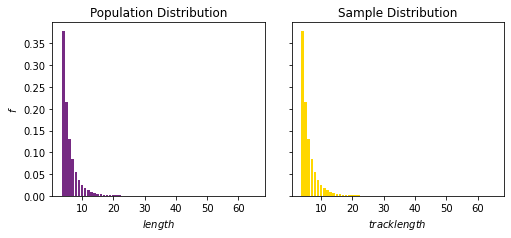

In [5]:
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True)
fig.tight_layout()

ax[0].set_title("Population Distribution")
ax[0].bar(x=freq_df.index, height=freq_df[POPULATION], color=COLORS[0], label=POPULATION)
ax[0].set_xlabel("$length$")
ax[0].set_ylabel("$f$")

ax[1].set_title("Sample Distribution")
ax[1].bar(x=freq_df.index, height=freq_df[SAMPLE], color=COLORS[2], label=SAMPLE)
ax[1].set_xlabel("$track length$")

plt.show()

Figure 9

In [6]:
def load_abs_cameras(filename: str) -> pd.Series:
    rel_cams = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, filename + ".pkl"))
    index = rel_cams.index
    abs_cams = pd.Series(convert_to_absolute_cameras(rel_cams), index=index, name="abs_" + filename)
    return abs_cams


def triangulate_landmark(track_data: pd.DataFrame, absolute_cameras: pd.Series):
    # triangulate the landmark based on the last camera
    last_frame_idx = track_data.index.max()
    cam = absolute_cameras[last_frame_idx]
    xl, xr, y = track_data.loc[last_frame_idx]
    landmark = triangulate(pixels1=np.array([xl, y]).reshape((2, 1)), pixels2=np.array([xr, y]).reshape((2, 1)), left_cam=cam)
    landmark = landmark.reshape((3, 1))
    return landmark

def calculate_pixel_error(cam, landmark, x: float, y: float) -> float:
    pixels = project(cam, landmark)[0]
    px, py = pixels
    return np.sqrt((px - x) ** 2 + (py - y) ** 2)


def calculate_reprojection_errors_by_frame(tracks: pd.DataFrame, absolute_cameras: pd.Series, verbose=False):
    start = time.time()
    if verbose:
        print("Calculating reprojection errors...")
    max_track_length = tracks.groupby(level=c.TrackIdx).size().max()
    left_errs = {d: [] for d in range(max_track_length + 1)}
    right_errs = {d: [] for d in range(max_track_length + 1)}

    for i, trk_idx in enumerate(tracks.index.unique(level=c.TrackIdx)):
        if verbose and i > 0 and i % 1000 == 0:
            print(f"\tfinished {i} tracks in {(time.time() - start):.2f} seconds")
        track_data = tracks.xs(trk_idx, level=c.TrackIdx)
        landmark = triangulate_landmark(track_data, absolute_cameras)

        # calculate reprojection error
        last_frame_idx = track_data.index.max()
        for fr_idx in track_data.index[::-1]:  # take index in descending order
            frame_distance = last_frame_idx - fr_idx
            xl, xr, y = track_data.loc[fr_idx]
            cam_left = absolute_cameras[fr_idx]

            left_error = calculate_pixel_error(cam_left, landmark, xl, y)
            left_errs[frame_distance].append(left_error)
            right_error = calculate_pixel_error(cam_left.get_right_camera(), landmark, xr, y)
            right_errs[frame_distance].append(right_error)

    left_errs = {k: pd.Series(v, dtype='float64') for k,v in left_errs.items()}
    right_errs = {k: pd.Series(v, dtype='float64') for k,v in right_errs.items()}
    elapsed = time.time() - start
    if verbose:
        print(f"Finished in {elapsed:.2f} seconds")
    return left_errs, right_errs

In [7]:
# load and calculate:

abs_pnp_cameras = load_abs_cameras("pnp_cameras")
pnp_errs_l, pnp_errs_r = calculate_reprojection_errors_by_frame(sample_tracks, abs_pnp_cameras, verbose=False)
pnp_median_err_l = pd.Series({k: v.median() for k,v in pnp_errs_l.items()})
pnp_median_err_r = pd.Series({k: v.median() for k,v in pnp_errs_r.items()})

abs_ba_cameras = load_abs_cameras("ba_cameras")
ba_errs_l, ba_errs_r = calculate_reprojection_errors_by_frame(sample_tracks, abs_ba_cameras, verbose=False)
ba_median_err_l = pd.Series({k: v.median() for k,v in ba_errs_l.items()})
ba_median_err_r = pd.Series({k: v.median() for k,v in ba_errs_r.items()})

# abs_pg_cameras = load_abs_cameras("pg_cameras")
# pg_errs_l, pg_errs_r = calculate_reprojection_errors_by_frame(sample_tracks, abs_pg_cameras, verbose=False)
# pg_median_err_l = pd.Series({k: v.median() for k,v in pg_errs_l.items()})
# pg_median_err_r = pd.Series({k: v.median() for k,v in pg_errs_r.items()})

median_factor_errors = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "track_factor_errors.pkl"))

<Figure size 432x288 with 0 Axes>

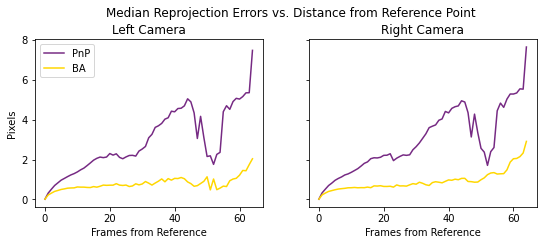

In [24]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(9, 3))
fig.subplots_adjust(top=0.9)
fig.suptitle("Median Reprojection Errors vs. Distance from Reference Point", y=1.05, x=0.52)

axes[0].set_title("Left Camera")
axes[0].plot(pnp_median_err_l.index, pnp_median_err_l, c=COLORS[0], label="PnP")
axes[0].plot(ba_median_err_l.index, ba_median_err_l, c=COLORS[2], label="BA")
axes[0].set_xlabel("Frames from Reference")
axes[0].set_ylabel("Pixels")
axes[0].legend()

axes[1].set_title("Right Camera")
axes[1].plot(pnp_median_err_r.index, pnp_median_err_r, c=COLORS[0], label="PnP")
axes[1].plot(ba_median_err_r.index, ba_median_err_r, c=COLORS[2], label="BA")
axes[1].set_xlabel("Frames from Reference")

plt.show()

<Figure size 432x288 with 0 Axes>

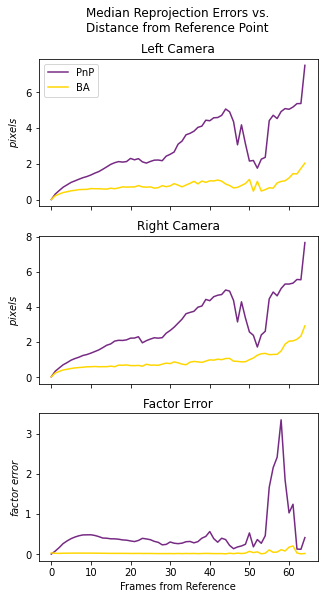

In [28]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=1, sharex='col', figsize=(5, 9))
fig.subplots_adjust(top=0.9)
fig.suptitle("Median Reprojection Errors vs.\nDistance from Reference Point", y=0.98, x=0.51)

axes[0].set_title("Left Camera")
axes[0].plot(pnp_median_err_l.index, pnp_median_err_l, c=COLORS[0], label="PnP")
axes[0].plot(ba_median_err_l.index, ba_median_err_l, c=COLORS[2], label="BA")
# axes[0].set_xlabel("Frames from Reference")
axes[0].set_ylabel("$pixels$")
axes[0].legend()

axes[1].set_title("Right Camera")
axes[1].plot(pnp_median_err_r.index, pnp_median_err_r, c=COLORS[0], label="PnP")
axes[1].plot(ba_median_err_r.index, ba_median_err_r, c=COLORS[2], label="BA")
# axes[1].set_xlabel("Frames from Reference")
axes[1].set_ylabel("$pixels$")

axes[2].set_title("Factor Error")
axes[2].plot(median_factor_errors.index, median_factor_errors.Pre, c=COLORS[0], label="PnP")
axes[2].plot(median_factor_errors.index, median_factor_errors.Post, c=COLORS[2], label="BA")
axes[2].set_xlabel("Frames from Reference")
axes[2].set_ylabel("$factor$ $error$")

plt.show()

Figure 10

<Figure size 432x288 with 0 Axes>

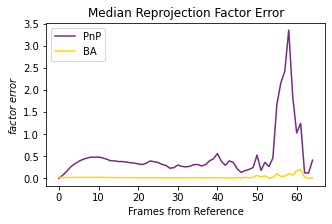

In [31]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))
# fig.subplots_adjust(top=0.9)
# fig.suptitle("Median Reprojection Errors vs.\nDistance from Reference Point", y=0.98, x=0.51)

axes.set_title("Median Reprojection Factor Error")
axes.plot(median_factor_errors.index, median_factor_errors.Pre, c=COLORS[0], label="PnP")
axes.plot(median_factor_errors.index, median_factor_errors.Post, c=COLORS[2], label="BA")
axes.set_xlabel("Frames from Reference")
axes.set_ylabel("$factor$ $error$")
axes.legend()

plt.show()

In [38]:
median_factor_errors.mean(), median_factor_errors.median()

(Pre     0.501171
 Post    0.028614
 dtype: float64,
 Pre     0.359423
 Post    0.017690
 dtype: float64)

#### DON'T READ FURTHER
##### THERE BE MONSTERS!
jk :-D but there are bugs down there

In [45]:
def calculate_distance(cam, landmark) -> float:
    cam_loc = (cam.calculate_coordinates())
    landmark = landmark.reshape(cam_loc.shape)
    return np.linalg.norm(cam_loc - landmark, ord=2, axis=0)


def calculate_reprojection_errors_by_distance(tracks: pd.DataFrame, absolute_cameras: pd.Series, verbose=False):
    start = time.time()
    if verbose:
        print("Calculating reprojection errors...")
    distances_left, distances_right = [], []
    errors_left, errors_right = [], []

    for i, trk_idx in enumerate(tracks.index.unique(level=c.TrackIdx)):
        if verbose and i > 0 and i % 1000 == 0:
            print(f"\tfinished {i} tracks in {(time.time() - start):.2f} seconds")
        track_data = tracks.xs(trk_idx, level=c.TrackIdx)
        landmark = triangulate_landmark(track_data, absolute_cameras)

        # calculate reprojection error
        last_frame_idx = track_data.index.max()
        for fr_idx in track_data.index[::-1]:  # take index in descending order
            xl, xr, y = track_data.loc[fr_idx]

            cam_left = absolute_cameras[fr_idx]
            distances_left.append(calculate_distance(cam_left, landmark))
            errors_left.append(calculate_pixel_error(cam_left, landmark, xl, y))

            cam_right = cam_left.get_right_camera()
            distances_right.append(calculate_distance(cam_right, landmark))
            errors_right.append(calculate_pixel_error(cam_right, landmark, xr, y))

    elapsed = time.time() - start
    if verbose:
        print(f"Finished in {elapsed:.2f} seconds")
    return distances_left, distances_right, errors_left, errors_right

In [46]:
# load and calculate:

abs_pnp_cameras = load_abs_cameras("pnp_cameras")
pnp_results = calculate_reprojection_errors_by_distance(sample_tracks, abs_pnp_cameras, verbose=False)
pnp_distances_left, pnp_distances_right, pnp_errors_left, pnp_errors_right = pnp_results

abs_ba_cameras = load_abs_cameras("ba_cameras")
ba_results = calculate_reprojection_errors_by_distance(sample_tracks, abs_ba_cameras, verbose=False)
ba_distances_left, ba_distances_right, ba_errors_left, ba_errors_right = ba_results

Figure 10
(there's a bug here but it's not interesting enough to explore further)

<Figure size 432x288 with 0 Axes>

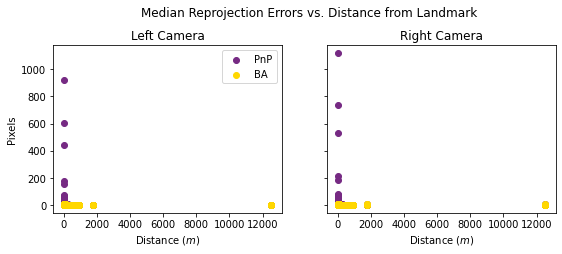

In [48]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(9, 3))
fig.subplots_adjust(top=0.9)
fig.suptitle("Median Reprojection Errors vs. Distance from Landmark", y=1.08, x=0.52)

axes[0].set_title("Left Camera")
axes[0].scatter(pnp_distances_left, pnp_errors_left, c=COLORS[0], label="PnP")
axes[0].scatter(ba_distances_left, ba_errors_left, c=COLORS[2], label="BA")
axes[0].set_xlabel("Distance ($m$)")
axes[0].set_ylabel("Pixels")
axes[0].legend()

axes[1].set_title("Right Camera")
axes[1].scatter(pnp_distances_right, pnp_errors_right, c=COLORS[0], label="PnP")
axes[1].scatter(ba_distances_right, ba_errors_right, c=COLORS[2], label="BA")
axes[1].set_xlabel("Distance ($m$)")

plt.show()

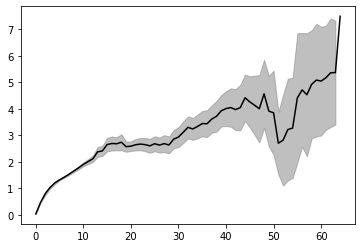

In [252]:
# there's no meaning behind this mean+sem visualization. better to use median

mean_err_l = pd.Series({k: v.mean() for k,v in pnp_errs_l.items()})
sem_err_l = pd.Series({k: v.sem() for k,v in pnp_errs_l.items()})

plt.clf()
plt.plot(mean_err_l.index, mean_err_l, 'k-')
plt.fill_between(mean_err_l.index, mean_err_l - sem_err_l, mean_err_l + sem_err_l, alpha=0.5, color='grey')

plt.show()